In [1]:
from src.utils import *
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, \
                                MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import warnings 
warnings.simplefilter('ignore')

### Simple Data Cleaning

In [2]:
# Load the original dataset
df = cleaning.load_data(config.orig_data_path)
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [3]:
# Data cleaning
df = cleaning.drop_nan(df, verbose=True)

Dropped 24 rows, 0.13% of original rows


In [4]:
# Formatting index and column names
df = cleaning.format_data(df)
df.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [5]:
# Value counts file dump
cleaning.dump_value_counts(config.value_counts_path, df, verbose=True)

Value counts information has been printed to src/data/tmp/value_counts.txt


In [6]:
# Save cleaned data
df.to_csv(config.cleaned_data_path)

### Benchmark models without EDA

In [7]:
# Load cleaned dataset
df = cleaning.load_data(config.cleaned_data_path, index_col=0)
eda.report(df)

,nan_count,dtype,unique
offer_accepted,0,object,2
reward,0,object,3
mailer_type,0,object,2
income_level,0,object,3
bank_accounts_open,0,int64,3
overdraft_protection,0,object,2
credit_rating,0,object,3
credit_cards_held,0,int64,4
homes_owned,0,int64,3
household_size,0,int64,8


In [8]:
# Benchmark Logistic Regressor Model
cols_ord_encod = ['income_level', 'credit_rating']
cols_onehot_encod = ['reward', 'mailer_type', 'overdraft_protection', 
                     'own_your_home']
predictions, classification_report = sktools.score_classification_model(
    df=df, target='offer_accepted', model=LogisticRegression(solver='lbfgs'),
    cols_to_encode=[cols_ord_encod, cols_onehot_encod],
    scaler=StandardScaler(),
    encoders=[OrdinalEncoder(), OneHotEncoder()],
    outsiders_thresh=None
)

print(classification_report)

              precision    recall  f1-score   support

          No       0.94      1.00      0.97      5079
         Yes       0.00      0.00      0.00       314

    accuracy                           0.94      5393
   macro avg       0.47      0.50      0.49      5393
weighted avg       0.89      0.94      0.91      5393



In [9]:
# Benchmark Knn Regressor Model
cols_ord_encod = ['income_level', 'credit_rating']
cols_onehot_encod = ['reward', 'mailer_type', 'overdraft_protection', 
                     'own_your_home']
predictions, classification_report = sktools.score_classification_model(
    df=df, target='offer_accepted', model=KNeighborsClassifier(),
    cols_to_encode=[cols_ord_encod, cols_onehot_encod],
    scaler=StandardScaler(),
    encoders=[OrdinalEncoder(), OneHotEncoder()],
    outsiders_thresh=None
)

print(classification_report)

              precision    recall  f1-score   support

          No       0.94      1.00      0.97      5079
         Yes       0.19      0.01      0.02       314

    accuracy                           0.94      5393
   macro avg       0.57      0.50      0.50      5393
weighted avg       0.90      0.94      0.91      5393



In [10]:
# Benchmark Knn Regressor Model (all onehot)
cols_onehot_encod = ['reward', 'mailer_type', 'overdraft_protection', 
                     'own_your_home', 'income_level', 'credit_rating']
predictions, classification_report = sktools.score_classification_model(
    df=df, target='offer_accepted', model=KNeighborsClassifier(),
    cols_to_encode=[cols_onehot_encod],
    scaler=StandardScaler(),
    encoders=[OneHotEncoder()],
    outsiders_thresh=None
)

print(classification_report)

              precision    recall  f1-score   support

          No       0.94      1.00      0.97      5079
         Yes       0.20      0.01      0.02       314

    accuracy                           0.94      5393
   macro avg       0.57      0.50      0.49      5393
weighted avg       0.90      0.94      0.91      5393



Logistic Regression model simply is not able to predict any credict cart offer <br> acceptance. <br>
Precision is zero and recall is zero. Probably due to really high imbalance of <br>
target data.<br>
KN Classifier performs definitely better, maybe it is the right algorithm for the <br>
problem, once EDA, correaltions and data imbalace are taken into account. <br>
Other classification algorithm to try:
1. Random Forest;
2. Support Vector Machine
3. Naive Bayes

### EDA

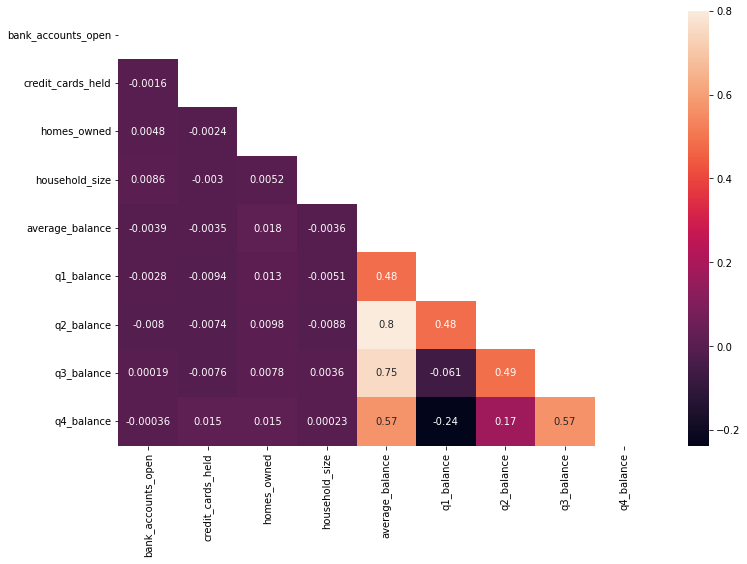

In [11]:
# Take a look to correlation heatmap
eda.show_corr_heatmap(df, figsize=(12, 8))

In [12]:
# Following couples present multicollinearity
mult_coll = eda.report_multicoll(df)
mult_coll

,feat1,feat2,corr
0,average_balance,q2_balance,0.800285
1,average_balance,q4_balance,0.572380
2,average_balance,q3_balance,0.752741
3,average_balance,q1_balance,0.481507
4,q1_balance,q2_balance,0.483134
5,q2_balance,q3_balance,0.487710
6,q3_balance,q4_balance,0.565298


### Models optimization
1. Multicollinearity 
2. Scaling/Encoding
3. Outliers
4. Feature Engineering
5. Fearue reduction
6. Imbalanced data
7. ML model optimization (optimal k for KNClassifier)

With multicollinearity accounted, I see strong relation with avg_balance and <br> all the q-balances. As a first measure I drop avg_balance and I keep only <br> q1 and q3 balances due to their low correlation factors (more distance <br> in time). Model increase precision from 0.20 to 0.25.

In [13]:
# Benchmark Knn Regressor Model (all onehot) and accounted multicoll
df1 = df.drop(['average_balance', 'q2_balance', 'q4_balance'], axis=1)
cols_onehot_encod = ['reward', 'mailer_type', 'overdraft_protection', 
                     'own_your_home', 'income_level', 'credit_rating']
predictions, classification_report = sktools.score_classification_model(
    df=df1, target='offer_accepted', model=KNeighborsClassifier(),
    cols_to_encode=[cols_onehot_encod],
    scaler=StandardScaler(),
    encoders=[OneHotEncoder()],
    outsiders_thresh=None
)

print(classification_report)

              precision    recall  f1-score   support

          No       0.94      1.00      0.97      5079
         Yes       0.25      0.03      0.05       314

    accuracy                           0.94      5393
   macro avg       0.60      0.51      0.51      5393
weighted avg       0.90      0.94      0.91      5393



Optimize scaling. It can be noted StandardScaler() obtains best results.

In [14]:
# Benchmark Knn Regressor Model (all onehot), accounted multicoll, different 
# scalers
scalers = [StandardScaler(), MinMaxScaler(), Normalizer()]
df1 = df.drop(['average_balance', 'q2_balance', 'q4_balance'], axis=1)
cols_onehot_encod = ['reward', 'mailer_type', 'overdraft_protection', 
                    'own_your_home', 'income_level', 'credit_rating']
for scaler in scalers:
    predictions, classification_report = sktools.score_classification_model(
        df=df1, target='offer_accepted', model=KNeighborsClassifier(),
        cols_to_encode=[cols_onehot_encod],
        scaler=scaler,
        encoders=[OneHotEncoder()],
        outsiders_thresh=None
    )
    print(str(scaler).strip('()'))
    print(classification_report)
    print('-'*55)

StandardScaler
              precision    recall  f1-score   support

          No       0.94      1.00      0.97      5079
         Yes       0.25      0.03      0.05       314

    accuracy                           0.94      5393
   macro avg       0.60      0.51      0.51      5393
weighted avg       0.90      0.94      0.91      5393

-------------------------------------------------------
MinMaxScaler
              precision    recall  f1-score   support

          No       0.94      0.99      0.97      5079
         Yes       0.11      0.02      0.03       314

    accuracy                           0.94      5393
   macro avg       0.53      0.50      0.50      5393
weighted avg       0.89      0.94      0.91      5393

-------------------------------------------------------
Normalizer
              precision    recall  f1-score   support

          No       0.94      1.00      0.97      5079
         Yes       0.22      0.01      0.02       314

    accuracy                   

Optimize the k